### 1 - Import test data

In [1]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tqdm.pandas()

def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    df["Gmt time"] = df["Gmt time"].str.replace(".000", "")
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
    df = df[df.High != df.Low]
    df.set_index("Gmt time", inplace=True)
    return df

def read_data_folder(folder_path="./data"):
    dataframes = []
    file_names = []
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = read_csv_to_dataframe(file_path)
            dataframes.append(df)
            file_names.append(file_name)
    return dataframes, file_names

def total_signal(df, current_candle):
    current_pos = df.index.get_loc(current_candle)
    c1 = df['Low'].iloc[current_pos] > df['Low'].iloc[current_pos - 1]
    c2 = df['Low'].iloc[current_pos-1] < df['Low'].iloc[current_pos - 2]
    c3 = ( (df['Close'].iloc[current_pos] - df['Close'].iloc[current_pos-1])/df['Close'].iloc[current_pos-1] ) > 0.005

    if c1 and c2 and c3:
        return 2
    
    c1 = df['High'].iloc[current_pos] < df['High'].iloc[current_pos - 1]
    c2 = df['High'].iloc[current_pos-1] > df['High'].iloc[current_pos - 2]
    c3 = ( (df['Close'].iloc[current_pos-1] - df['Close'].iloc[current_pos])/df['Close'].iloc[current_pos] ) > 0.005

    if c1 and c2 and c3:
        return 1

    return 0

# def total_signal(df, current_candle, threshold=0.001):
#     current_pos = df.index.get_loc(current_candle)
    
#     # Calculate the low and high differences
#     low_diff1 = (df['Low'].iloc[current_pos] - df['Low'].iloc[current_pos - 1]) / df['Low'].iloc[current_pos - 1]
#     low_diff2 = (df['Low'].iloc[current_pos - 2] - df['Low'].iloc[current_pos - 1]) / df['Low'].iloc[current_pos - 1]
#     high_diff1 = (df['High'].iloc[current_pos - 1] - df['High'].iloc[current_pos]) / df['High'].iloc[current_pos]
#     high_diff2 = (df['High'].iloc[current_pos - 1] - df['High'].iloc[current_pos - 2]) / df['High'].iloc[current_pos - 2]
    
#     # Calculate the close price differences
#     close_diff_up = (df['Close'].iloc[current_pos] - df['Close'].iloc[current_pos - 1]) / df['Close'].iloc[current_pos - 1]
#     close_diff_down = (df['Close'].iloc[current_pos - 1] - df['Close'].iloc[current_pos]) / df['Close'].iloc[current_pos]
    
#     # Check conditions for signal 2
#     c1 = low_diff1 > threshold
#     c2 = low_diff2 > threshold
#     c3 = close_diff_up > 0.001

#     if c1 and c2 and c3:
#         return 2
    
#     # Check conditions for signal 1
#     c1 = high_diff1 > threshold
#     c2 = high_diff2 > threshold
#     c3 = close_diff_down > 0.001

#     if c1 and c2 and c3:
#         return 1

#     return 0



def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name), axis=1)
    return df

def add_pointpos_column(df, signal_column):
    """
    Adds a 'pointpos' column to the DataFrame to indicate the position of support and resistance points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with the specified SR column, 'Low', and 'High' columns.
    sr_column (str): The name of the column to consider for the SR (support/resistance) points.
    
    Returns:
    DataFrame: The original DataFrame with an additional 'pointpos' column.
    """
    def pointpos(row):
        if row[signal_column] == 2:
            return row['Low'] - 1e-4
        elif row[signal_column] == 1:
            return row['High'] + 1e-4
        else:
            return np.nan

    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    return df

def plot_candlestick_with_signals(df, start_index, num_rows):
    """
    Plots a candlestick chart with signal points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'Open', 'High', 'Low', 'Close', and 'pointpos' columns.
    start_index (int): The starting index for the subset of data to plot.
    num_rows (int): The number of rows of data to plot.
    
    Returns:
    None
    """
    df_subset = df[start_index:start_index + num_rows]
    
    fig = make_subplots(rows=1, cols=1)
    
    fig.add_trace(go.Candlestick(x=df_subset.index,
                                 open=df_subset['Open'],
                                 high=df_subset['High'],
                                 low=df_subset['Low'],
                                 close=df_subset['Close'],
                                 name='Candlesticks'),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset['pointpos'], mode="markers",
                             marker=dict(size=10, color="MediumPurple", symbol='circle'),
                             name="Entry Points"),
                  row=1, col=1)
    
    fig.update_layout(
        width=1200, 
        height=800, 
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        showlegend=True,
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="white"
            ),
            bgcolor="black",
            bordercolor="gray",
            borderwidth=2
        )
    )
    
    fig.show()

In [2]:
ldf, names = read_data_folder()

100%|██████████| 5/5 [00:00<00:00, 42.13it/s]


In [3]:
names

['AUDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'NZDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDCHF_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDJPY_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']

In [4]:
folder_path = "./data"
dataframes, file_names = read_data_folder(folder_path)

for i, df in enumerate(dataframes):
    print("working on dataframe ", i, "...")
    df = add_total_signal(df)
    df = add_pointpos_column(df, "TotalSignal")
    dataframes[i] = df  # Update the dataframe in the list
    

100%|██████████| 5/5 [00:00<00:00, 108.99it/s]


working on dataframe  0 ...


100%|██████████| 2197/2197 [00:00<00:00, 13766.18it/s]


working on dataframe  1 ...


100%|██████████| 2197/2197 [00:00<00:00, 14031.38it/s]


working on dataframe  2 ...


100%|██████████| 2195/2195 [00:00<00:00, 14198.75it/s]


working on dataframe  3 ...


100%|██████████| 2197/2197 [00:00<00:00, 14031.23it/s]


working on dataframe  4 ...


100%|██████████| 2197/2197 [00:00<00:00, 13597.71it/s]


In [5]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)


TotalSignal
0    9941
1     547
2     495
Name: count, dtype: int64

In [6]:
plot_candlestick_with_signals(dataframes[0], start_index=0, num_rows=355)

In [9]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class Strat_01(Strategy):
    mysize = 0.1  # Trade size
    slperc = 0.02
    tpperc = 0.04

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def next(self):
        super().next()
         
        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL and TP
            current_close = self.data.Close[-1]
            sl = current_close - self.slperc * current_close  # SL at 4% below the close price
            tp = current_close + self.tpperc * current_close  # TP at 2% above the close price
            self.buy(size=self.mysize, sl=sl, tp=tp)

        elif self.signal1 == 1 and not self.position:
            # Open a new short position, setting SL based on a strategy-specific requirement
            current_close = self.data.Close[-1]
            sl = current_close + self.slperc * current_close  # SL at 4% below the close price
            tp = current_close - self.tpperc * current_close  # TP at 2% above the close price
            self.sell(size=self.mysize, sl=sl, tp=tp)


In [23]:
import pandas as pd
from backtesting import Strategy

class Strat_02(Strategy):
    mysize = 0.2  # Trade size

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        self.ordertime = []  # Track order times

    def next(self):
        super().next()

        # Cancel orders older than 2 days
        self.cancel_old_orders()

        # Check if any trades are winning and close them if they were opened for less than 3 days,
        # otherwise close the trades after 3 days regardless of profit or loss
        self.manage_trades()

        # Handle new signals
        self.handle_signals()

    def cancel_old_orders(self):
        i = 0
        while i < len(self.orders):
            order_age = self.data.index[-1] - self.ordertime[i]
            if order_age > pd.Timedelta(days=2):
                self.orders[i].cancel()
                self.ordertime.pop(i)
            else:
                i += 1

    def manage_trades(self):
        for trade in self.trades:
            trade_duration = self.data.index[-1] - trade.entry_time

            if trade_duration >= pd.Timedelta(days=2) or trade.pl > 0:
                trade.close()

    def handle_signals(self):
        if self.signal1[-1] == 2 and not self.position:
            self.cancel_all_orders()
            self.buy(size=self.mysize, stop=self.data.High[-1])
            self.ordertime.append(self.data.index[-1])

        elif self.signal1[-1] == 1 and not self.position:
            self.cancel_all_orders()
            self.sell(size=self.mysize, stop=self.data.Low[-1])
            self.ordertime.append(self.data.index[-1])

    def cancel_all_orders(self):
        while self.orders:
            self.orders[0].cancel()
            self.ordertime.pop(0)


In [24]:
results = []

for df in dataframes:
    bt = Backtest(df, Strat_02, cash=5000, margin=1/5, commission=0.0002)
    # stats, heatmap = bt.optimize(slperc=[i/100 for i in range(1, 8)],
    #                              tpperc=[i/100 for i in range(1, 8)],
    #                 maximize='Return [%]', max_tries=3000,
    #                     random_state=0,
    #                     return_heatmap=True)
    
    stats =  bt.run()

    results.append(stats)

In [25]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
#max_trade_duration = max([r["Max. Trade Duration"] for r in results])
#avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
#print(f"Maximum Trade Duration: {max_trade_duration} days")
#print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: -5.70%
Number of Trades: 644
Maximum Drawdown: -10.01%
Average Drawdown: -2.18%
Win Rate: 61.52%
Best Trade: 2.87%
Worst Trade: -3.92%
Average Trade: -0.01%


In [15]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

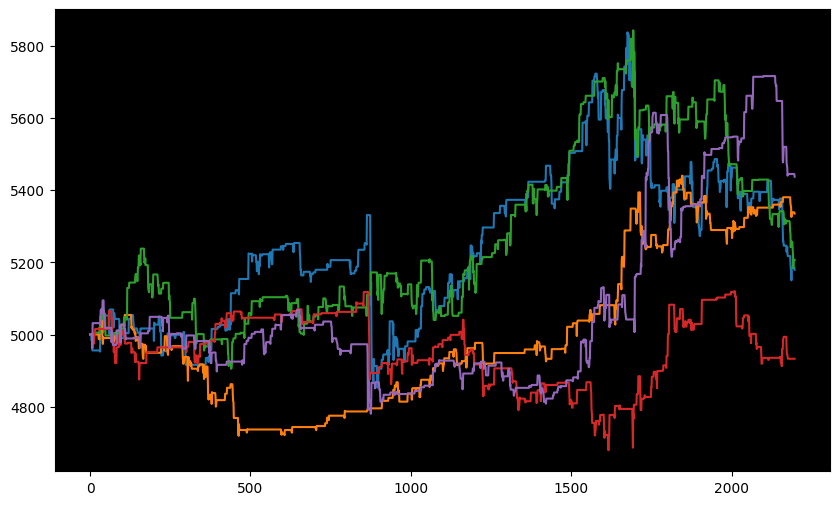

In [16]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=False).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')

In [17]:
[r["Return [%]"] for r in results]

[3.5887457105205973,
 6.7017632866003805,
 4.1405454378002835,
 -1.3431588323595498,
 8.745358268000327]

In [18]:
names

['AUDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'NZDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDCHF_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDJPY_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']

In [16]:
results[0]

Start                     2017-06-06 00:00:00
End                       2024-06-14 00:00:00
Duration                   2565 days 00:00:00
Exposure Time [%]                   28.857533
Equity Final [$]                   5321.27435
Equity Peak [$]                    5936.50318
Return [%]                           6.425487
Buy & Hold Return [%]              -11.940934
Return (Ann.) [%]                    0.716862
Volatility (Ann.) [%]                4.732595
Sharpe Ratio                         0.151473
Sortino Ratio                        0.210118
Calmar Ratio                         0.065843
Max. Drawdown [%]                  -10.887467
Avg. Drawdown [%]                   -1.339587
Max. Drawdown Duration      609 days 00:00:00
Avg. Drawdown Duration       70 days 00:00:00
# Trades                                  180
Win Rate [%]                             75.0
Best Trade [%]                       1.626991
Worst Trade [%]                      -8.21632
Avg. Trade [%]                    

In [17]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1330', ...)